# Feature Engineering
Now that the data has been succsefully merged into a format consisting of the stock prices, volume, brand, category, and review score the feature engineering phase can begin. The purpose of this section is to choose or create the most relevant features for our dataset that can help improve the ability of our model to generate results. These new features could combine several existing features information into one to improve preformance. These new features will also add more useful information such as quarterly and annual averages for the overall brand and category, the count of reviews per product and the amount of time the product has been on the market.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

In [2]:
brands = ['Whirlpool', 'Electrolux', 'GE', 'Samsung', 'Columbia', 'adidas','Nike', 'Vans', 'The North Face', 'Panasonic', 'Canon', 'Sony', 'Apple', 'Microsoft','LG', 'Nikon', 'Under Armour', 'Stanley Black & Decker', '3M','Honeywell', 'Activision', 'Electronic Arts', 'Nintendo','Ubisoft', 'Square Enix']
tickers = ['WHR', 'ELUXY', 'GE', 'SMSN.IL', 'COLM', 'ADDYY', 'NKE', 'VFC', 'VFC', 'PCRFY', 'CAJ', 'SNE', 'AAPL', 'MSFT', 'LPL', 'NINOY', 'UA', 'SWK', 'MMM', 'HON', 'ATVI', 'EA', 'NTDOY', 'UBSFF', 'SQNXF']
ticker_files = [ticker + '.csv' for ticker in tickers]
ticker_dict = {b:t_f for b, t_f in list(zip(brands, ticker_files))}

In [3]:
def monthly_change(df, col):
    # This function taking in our product category datasets and divides a column by its month_after values to give the monthly change value
    ma = col+'_month_after'
    return df[ma].div(df[col])

In [4]:
def product_cat_feature_processing(df):
    # This function takes in a product category dataset and 
    # To get a single value for a stocks price throughout the day we are taking the average of the stocks high and low for the day
    df['avg_price_daily'] = (df['Open'] + df['Close'])/2
    df['avg_price_daily_month_after'] = (df['Open_month_after'] + df['Close_month_after'])/2
    # To get the market cap for a stock for a given day the avg_price is multiplied by the volume
    df['market_cap'] = df['avg_price_daily'] * df['Volume']
    df['market_cap_month_after'] = df['avg_price_daily_month_after'] * df['Volume_month_after']
    df['Volume_monthly_change'] = monthly_change(df=df, col='Volume')
    # Using our monthly_change function the daily stock price and market cap monthly changes are generated into their own features
    df['avg_price_monthly_change'] = monthly_change(df=df, col='avg_price_daily')
    df['market_cap_monthly_change'] = monthly_change(df=df, col='market_cap')
    # Transform review scores into three categories
    df['ratings_cat'] = df['overall'].apply(lambda x: 1 if int(x) in range(0,3) else (2 if x in range(3,5) else 3))    
    
    brands = df['brand'].unique()
    def period_averages_prices(time_period):
        # This function takes in a time period to resample the data by and puts out a mean for review scores and stock prices within its category and brand.
        period_values = []
        for b in brands:
            ticker_df = pd.read_csv(ticker_dict[b], parse_dates=['Date'], index_col='Date')
            ticker_df['avg_price'] = (ticker_df['Open']+ticker_df['Close'])/2
            ticker_df['market_cap'] = ticker_df['avg_price'] * ticker_df['Volume']
            period_avgs = ticker_df.asfreq('1D', method='bfill').rolling(window=time_period).mean()[['avg_price', 'market_cap']].reset_index()
            period_avgs.columns = ['date_time', 'avg_daily_price_' + str(time_period), 'avg_market_cap_' + str(time_period)]
            period_avgs['brand'] = b
            period_values.append(period_avgs)
        
        period_df = pd.concat(period_values, axis=0)
        return period_df
    
    quarter_averages = period_averages_prices(time_period=90)
    annual_averages = period_averages_prices(time_period=365)
    monthly_averages = period_averages_prices(time_period=30)
    df = df.reset_index().merge(quarter_averages, on=['date_time', 'brand'])
    df = df.merge(annual_averages, on=['date_time', 'brand'])
    df = df.merge(monthly_averages, on=['date_time', 'brand'])
    return df
    
   

In [5]:
def period_review_averages(df, brands, time_period ,sub):
    # This function takes in a time period to resample the data by and puts out a mean for review scores and stock prices within its category and brand.
    period_values = []
    for b in brands:
        b_df = df[df['brand'] == b].groupby(['date_time']).mean()[['overall','ratings_cat']].asfreq('D', method='bfill').rolling(window=time_period).mean()
        b_df['brand'] = b
        b_df.columns = ['mean_ratings_' + sub + '_' + str(time_period), 'ratings_cat_' + sub + '_' + str(time_period), 'brand']
        period_values.append(b_df)
        
    period_df = pd.concat(period_values, axis=0)
    return period_df

The functions above are the culmination of the steps taken to get the intial features for each product category. The first dataset that will be explored is the tools and home improvement category. This dataset was chosen due to its relatively lower size when compared to other categories. It's lower size results in lower memory requirements, making it faster to adjust and test our results.

In [6]:
tools = pd.read_csv('tools_stocks.csv', parse_dates=['month_after'], index_col='month_after').iloc[:,1:].dropna()
tools.sort_index(inplace=True)
tools.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409000 entries, 1999-12-06 to 2018-10-30
Data columns (total 17 columns):
Open                     409000 non-null float64
High                     409000 non-null float64
Low                      409000 non-null float64
Close                    409000 non-null float64
Adj Close                409000 non-null float64
Volume                   409000 non-null int64
brand                    409000 non-null object
date_time                409000 non-null object
asin                     409000 non-null object
overall                  409000 non-null float64
Open_month_after         409000 non-null float64
High_month_after         409000 non-null float64
Low_month_after          409000 non-null float64
Close_month_after        409000 non-null float64
Adj Close_month_after    409000 non-null float64
Volume_month_after       409000 non-null int64
cat                      409000 non-null object
dtypes: float64(11), int64(2), object(4)
memory 

In [7]:
# To get a single value for a stocks price throughout the day we are taking the average of the stocks high and low for the day
tools['avg_price_daily'] = (tools['Open'] + tools['Close'])/2
tools['avg_price_daily_month_after'] = (tools['Open_month_after'] + tools['Close_month_after'])/2

In [8]:
# To get the market cap for a stock for a given day the avg_price is multiplied by the volume
tools['market_cap'] = tools['avg_price_daily'] * tools['Volume']
tools['market_cap_month_after'] = tools['avg_price_daily_month_after'] * tools['Volume_month_after']
tools['Volume_monthly_change'] = monthly_change(df=tools, col='Volume')
# Using our monthly_change function the daily stock price and market cap monthly changes are generated into their own features
tools['avg_price_monthly_change'] = monthly_change(df=tools, col='avg_price_daily')
tools['market_cap_monthly_change'] = monthly_change(df=tools, col='market_cap')

## Reviews
When shopping on Amazon, a product is generally considered of poor quality when it has less than three stars. The difference of a rating between one and three stars is not as significant as the difference between a three star rating and a five star rating. There are also issues when looking at any one star review where many of them are regarding their shipping experience, issues with returning the product and not necessarily about the quality of the product itself. To address these issues, the scores could be represented as categories representing more general sentiments of the reviews. To determine the boundaries for these categories the review score data must be further examined.

Text(0.5, 1.0, 'Frequency Distribution of Review Scores')

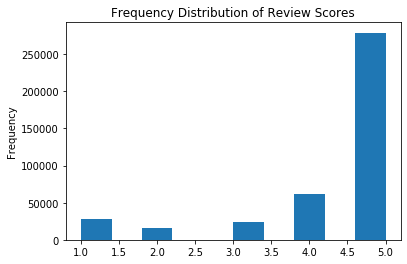

In [9]:
tools['overall'].plot(kind='hist', bins=10)
plt.title('Frequency Distribution of Review Scores')

From what we can see from our histogram, a large majority of the scores in this dataset are above 4.5 followed by reviews with a rating of 4.0 in a distant second place. To balance the categories in terms of what amount of quality they represent and not having a single category skew the results too heavily they will be divided into three ranges from scores between 0 to 2 representing poor reviews, scores between 3 to 4 representing good reviews, and scores between 4.1 to 5 representing excellent scores.

In [10]:
ratings = tools['overall'].values
ratings_cat = []
for r in ratings:
    if int(r) in range(0,3):
        ratings_cat.append(1)
    elif int(r) in range(3,5):
        ratings_cat.append(2)
    else:
        ratings_cat.append(3)
tools['ratings_cat'] = ratings_cat

(array([ 43647.,      0.,  86531.,      0., 278822.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. ]),
 <a list of 5 Patch objects>)

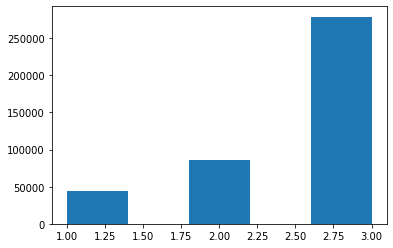

In [11]:
plt.hist(ratings_cat, bins=5)

In [12]:
tools.head()

,Open,High,Low,Close,Adj Close,Volume,brand,date_time,asin,overall,...,Volume_month_after,cat,avg_price_daily,avg_price_daily_month_after,market_cap,market_cap_month_after,Volume_monthly_change,avg_price_monthly_change,market_cap_monthly_change,ratings_cat
month_after,,,,,,,,,,,,,,,,,,,,,
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B00002X20X,5.0,...,291600,Tools_and_Home_Improvement,27.46875,31.6250,8347753.125,9221850.00,0.959526,1.151308,1.104710,3
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B0000302UJ,5.0,...,291600,Tools_and_Home_Improvement,27.46875,31.6250,8347753.125,9221850.00,0.959526,1.151308,1.104710,3
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B00002X20X,5.0,...,291600,Tools_and_Home_Improvement,27.46875,31.6250,8347753.125,9221850.00,0.959526,1.151308,1.104710,3
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B0000302UJ,5.0,...,291600,Tools_and_Home_Improvement,27.46875,31.6250,8347753.125,9221850.00,0.959526,1.151308,1.104710,3
1999-12-10,30.4375,31.375,30.250,31.1250,18.619738,270100,Stanley Black & Decker,1999-11-12,B00002X1XB,5.0,...,144900,Tools_and_Home_Improvement,30.78125,31.3125,8314015.625,4537181.25,0.536468,1.017259,0.545727,3


## Brands
One of the core goals of this project is to test whether Amazon product reviews have an impact on stock prices. A brand's stock prices and aggregate review scores are both highly variable from day to day. One way to capture these values while decreasing the varation is to look at their averages over a longer period of time such as quarterly and annual averages. 


Stanley Black & Decker    285083
Honeywell                  46910
GE                         40865
3M                         36142
Name: brand, dtype: int64


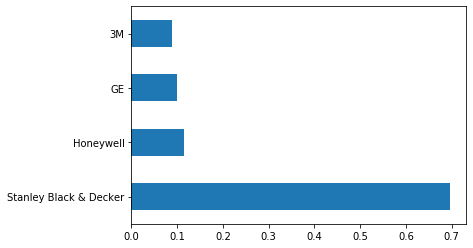

In [13]:
t_brands = tools['brand'].value_counts().index.values
print(tools['brand'].value_counts())
tools['brand'].value_counts(normalize=True).plot(kind='barh')

Stanley Black & Decker products make up roughly 70% of the total product reviews in dataset. The reason for this is that Stanley Black & Decker is conglomerate of several leading brands solely focused in the tools and home improvement industry such as Black & Decker, Stanley and Dewault. The other brands listed have many products in the appliances category. Below are the quarterly review scores along with their quarterly average market cap one month after the time of the review score.

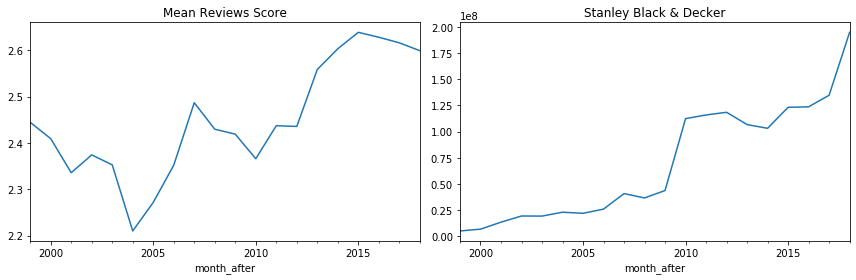

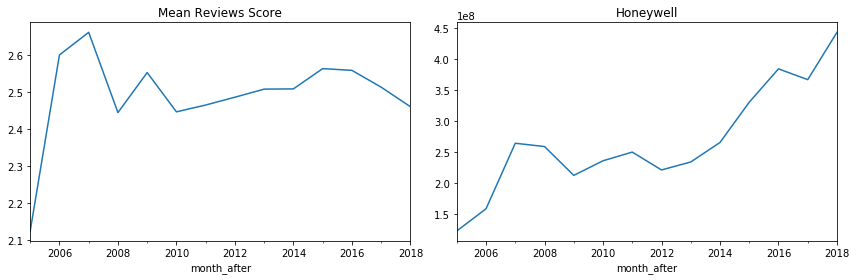

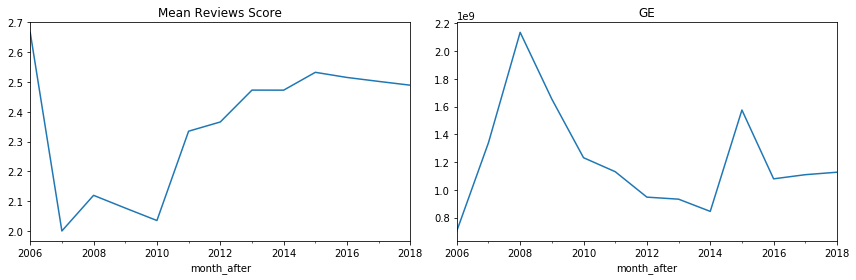

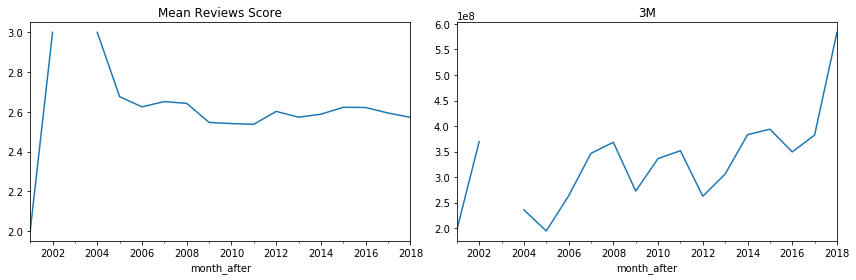

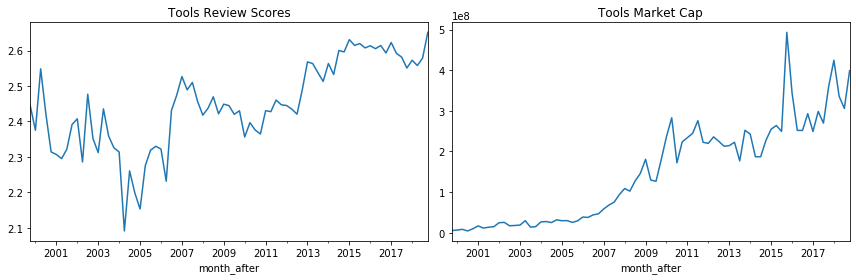

In [14]:
for b in t_brands:
    df = tools[tools['brand'] == b].resample('A').mean()
    plt.subplots(1,2, figsize=[12,4])
    plt.subplot(1,2,1)
    df['ratings_cat'].plot(title='Mean Reviews Score')
    plt.subplot(1,2,2)
    df['market_cap_month_after'].plot()
    plt.tight_layout()
    plt.title(b)
    plt.show()
    
plt.subplots(1,2, figsize=[12,4])
plt.subplot(1,2,1)
tools.resample('QS').mean()['ratings_cat'].plot(title='Tools Review Scores')
plt.subplot(1,2,2)
tools.resample('QS').mean()['market_cap_month_after'].plot()
plt.tight_layout()
plt.title('Tools Market Cap')
plt.show()

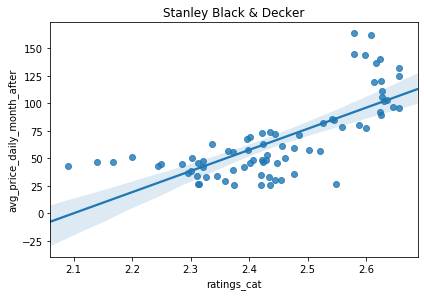

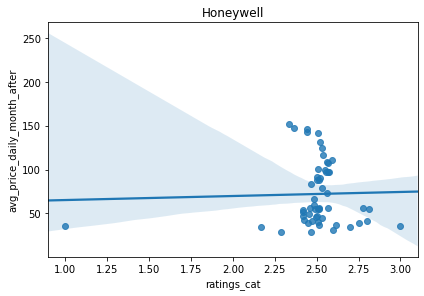

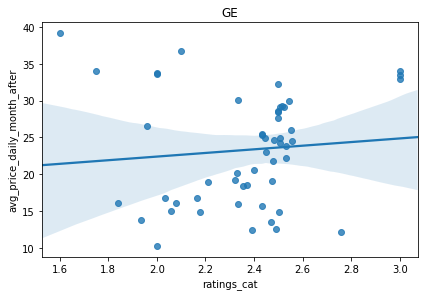

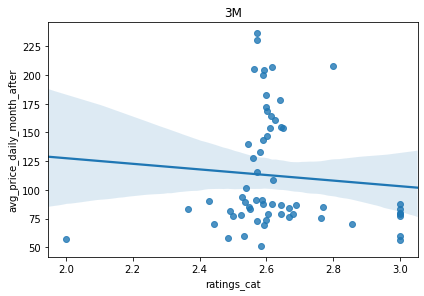

In [15]:
for b in t_brands:
    df = tools[tools['brand'] == b].resample('Q').mean()
    sns.regplot(x='ratings_cat', y ='avg_price_daily_month_after', data=df)
    plt.tight_layout()
    plt.title(b)
    plt.show()


From the scatterplots above, the only brand that showed any sign of a significant relationship was Stanley Black & Decker. Stanley Black & Decker also has a far higher number of values within the tools product category. Following this process, quarterly, yearly, and monthly averages for the review scores, market cap, and average stock prices will be added to the dataset.

In [16]:
quarterly_averages = []
for b in t_brands:
    b_df = tools[tools['brand'] == b].groupby(['month_after']).mean()[['overall','ratings_cat','market_cap_month_after','avg_price_daily', 'avg_price_daily_month_after']].resample('QS', level='month_after').mean().asfreq('D', method='ffill')
    b_df['brand'] = b
    b_df.columns = ['mean_ratings_q','ratings_cat_q', 'market_cap_q', 'avg_price_q', 'avg_price_q_month_after', 'brand']
    quarterly_averages.append(b_df)
    
t_q = pd.concat(quarterly_averages, axis=0)

In [17]:
annual_averages = []
for b in t_brands:
    b_df = tools[tools['brand'] == b].groupby(['month_after']).mean()[['overall', 'ratings_cat', 'market_cap_month_after', 'avg_price_daily', 'avg_price_daily_month_after']].resample('A', level='month_after').mean().asfreq('D', method='ffill')
    b_df['brand'] = b
    b_df.columns = ['mean_ratings_a','ratings_cat_a', 'market_cap_a', 'avg_price_a', 'avg_price_a_month_after', 'brand']
    annual_averages.append(b_df)
    
t_a = pd.concat(annual_averages, axis=0)


In [18]:
monthly_averages = []
for b in t_brands:
    b_df = tools[tools['brand'] == b].groupby(['month_after']).mean()[['overall', 'ratings_cat', 'market_cap_month_after', 'avg_price_daily', 'avg_price_daily_month_after']].resample('M', level='month_after').mean().asfreq('D', method='ffill')
    b_df['brand'] = b
    b_df.columns = ['mean_ratings_m','ratings_cat_m', 'market_cap_m', 'avg_price_m', 'avg_price_m_month_after', 'brand']
    monthly_averages.append(b_df)
    
t_m = pd.concat(monthly_averages, axis=0)

In [19]:
qq = tools.reset_index().merge(t_q, on=['month_after', 'brand'])

In [20]:
aa = qq.merge(t_a, on=['month_after', 'brand'])

In [21]:
mm = aa.merge(t_m, on=['month_after', 'brand'])

## Looking at the big picture
The functions written in the heading of this notebook will be used to process the previous steps taken on the tools dataset and apply those steps to the rest of the product category datasets. From this larger dataset encompassing all of our product categorys, the same time period averages for review scores can be accounted for the entire brand compared to a the average review scores within its category.

In [22]:
product_cats = ['appliances_stocks.csv', 'Clothing_stocks.csv', 'electronics_stocks.csv', 'sport_stocks.csv', 'tools_stocks.csv', 'video_game_stocks.csv']
dfs = [pd.read_csv(cat, parse_dates=['date_time'], index_col='date_time', low_memory=False).sort_index() for cat in product_cats]
cat_df = pd.concat([product_cat_feature_processing(df) for df in dfs], axis=0)

In [23]:
# This section adds the period averages for a brands overall review scores seperate from its product category
cat_df.reset_index(inplace=True)
for p in [30, 90, 365]:
    p_df = period_review_averages(cat_df, cat_df.brand.unique(), p, 'brand')
    cat_df = cat_df.merge(p_df, on=['date_time', 'brand'])
    
cat_df.dropna(inplace=True)

In [24]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176503 entries, 28 to 3323961
Data columns (total 40 columns):
index                          int64
date_time                      datetime64[ns]
Unnamed: 0                     int64
Open                           float64
High                           float64
Low                            float64
Close                          float64
Adj Close                      float64
Volume                         float64
brand                          object
asin                           object
overall                        float64
month_after                    object
Open_month_after               float64
High_month_after               float64
Low_month_after                float64
Close_month_after              float64
Adj Close_month_after          float64
Volume_month_after             float64
cat                            object
avg_price_daily                float64
avg_price_daily_month_after    float64
market_cap                   

Another useful feature might be how many reviews a specific product has on the date that the review occurred on. This will inform our model how the amount of reviews could impact the review score

In [26]:
# The first step is to group the dataset by date and product_id, then through a seconding grouping by product_id the cummulative sum  for each respective date can be derived
asin_cs = cat_df.groupby(['asin','date_time']).count().iloc[:,-1].groupby('asin').cumsum().reset_index()
asin_cs.columns = ['asin', 'date_time', 'asin_cs']
cat_df = cat_df.merge(asin_cs, on=['asin', 'date_time'])

How long the product has been on the market could have an impact on it's review scores because a product that has been on the market longer will have more reviews. To represent this within the dataset each date can be subtracted from the most recent date that review occured on. In the dataset, this time delta will be represented as a proportion from most recent to least recent.

In [27]:
max_ma = cat_df['date_time'].max()
delta = cat_df['date_time'].apply(lambda x: ((max_ma - x).days))
dd = delta/delta.max()
cat_df['days_on_market'] = dd

In [28]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176503 entries, 0 to 3176502
Data columns (total 43 columns):
level_0                        int64
index                          int64
date_time                      datetime64[ns]
Unnamed: 0                     int64
Open                           float64
High                           float64
Low                            float64
Close                          float64
Adj Close                      float64
Volume                         float64
brand                          object
asin                           object
overall                        float64
month_after                    object
Open_month_after               float64
High_month_after               float64
Low_month_after                float64
Close_month_after              float64
Adj Close_month_after          float64
Volume_month_after             float64
cat                            object
avg_price_daily                float64
avg_price_daily_month_after    f

## Feature Selection
The dataset above has over 49 columns and much of it is redundant information. The model that will be deployed is trying to predict a brand's stock price after one month of the time of the review. Therefore most of the features containing information regarding the price of a stock or market cap value on the day of the review do not provide much useful information. When the review scores were put into three categories instead of on a scale of one to five our the additional columns regarding the preiodical averages for the original review scores do not provide us with much useful information. Lastly, from determining the average price of a stock, market cap, and monthly change, the stocks opening, closing and volume values also become redundant. The features that we are left with are listed below and taken to form a revised dataset.

In [29]:
cols = ['date_time','brand', 'cat','overall','avg_price_daily', 'avg_price_monthly_change', 'avg_daily_price_30', 'avg_daily_price_90', 'avg_daily_price_365', 'market_cap','market_cap_monthly_change', 'avg_market_cap_30', 'avg_market_cap_90', 'avg_market_cap_365','ratings_cat','ratings_cat_brand_30', 'ratings_cat_brand_90', 'ratings_cat_brand_365', 'asin_cs', 'days_on_market']
cat_df = cat_df[cols]
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176503 entries, 0 to 3176502
Data columns (total 20 columns):
date_time                    datetime64[ns]
brand                        object
cat                          object
overall                      float64
avg_price_daily              float64
avg_price_monthly_change     float64
avg_daily_price_30           float64
avg_daily_price_90           float64
avg_daily_price_365          float64
market_cap                   float64
market_cap_monthly_change    float64
avg_market_cap_30            float64
avg_market_cap_90            float64
avg_market_cap_365           float64
ratings_cat                  int64
ratings_cat_brand_30         float64
ratings_cat_brand_90         float64
ratings_cat_brand_365        float64
asin_cs                      int64
days_on_market               float64
dtypes: datetime64[ns](1), float64(15), int64(2), object(2)
memory usage: 508.9+ MB


## One hot encoding categories and brands
In order to model this dataset, it is important to encode the categorical variables into dummies so that our eventual model will retain their information. The categorical variables for this case are the reviews associated brand, product_category, and review_category 

In [30]:
model_df = pd.concat([cat_df, pd.get_dummies(cat_df.ratings_cat, prefix='rating_cat'), pd.get_dummies(cat_df.cat), pd.get_dummies(cat_df.brand)], axis=1).drop(['ratings_cat', 'overall', 'cat', 'brand', 'date_time', 'market_cap_monthly_change'], axis=1)

In [31]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176503 entries, 0 to 3176502
Data columns (total 47 columns):
avg_price_daily               float64
avg_price_monthly_change      float64
avg_daily_price_30            float64
avg_daily_price_90            float64
avg_daily_price_365           float64
market_cap                    float64
avg_market_cap_30             float64
avg_market_cap_90             float64
avg_market_cap_365            float64
ratings_cat_brand_30          float64
ratings_cat_brand_90          float64
ratings_cat_brand_365         float64
asin_cs                       int64
days_on_market                float64
rating_cat_1                  uint8
rating_cat_2                  uint8
rating_cat_3                  uint8
Appliances                    uint8
Clothing                      uint8
Electronics                   uint8
Sports_and_Outdoors           uint8
Tools_and_Home_Improvement    uint8
Video Games                   uint8
3M                            uin

## Target Variable
The feature that we are trying to predict is whether or not the the brands stock price had changed in a positive or negative way. To measure this we can apply a function to our monthly change variable to represent negative changes as a 0 and positive changes as 1. 

In [33]:
model_df['y_change'] = model_df['avg_price_monthly_change'].apply(lambda x: 0 if x < 1 else 1)